# Problem : Linear Calibration (Thermometer)

- **Task:** Map “unknown-scale” readings $t_u$ to true Celsius $t_c$ using a linear model.

$$
t_p = w\, t_u + b
$$

- **Interpretation:**
  - $w$: gain/scale (stretch/squeeze)
  - $b$: offset/bias (systematic shift)
- **Why linear?** Sensors are often approximately affine over normal ranges.
- **Goal:** Find $w,b$ that make predictions $t_p$ close to targets $t_c$ using mnnaually coded loss, gradient functions.


# Imports

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

print(sys.version)
print(torch.__version__)
print(np.__version__)

3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:28:53) [Clang 19.1.7 ]
2.8.0
2.3.4


# Dataset

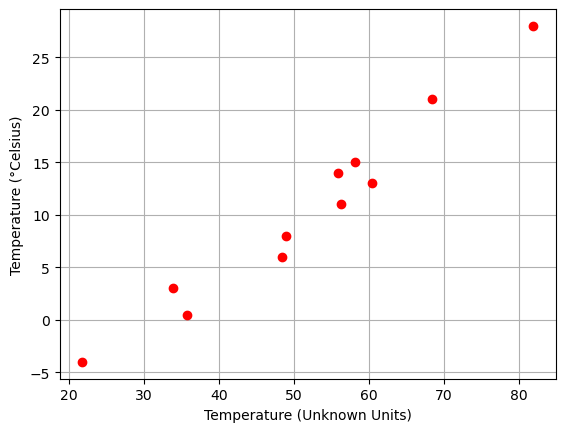

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o', color='red')
plt.xlabel('Temperature (Unknown Units)')
plt.ylabel('Temperature (°Celsius)')
plt.show()

In [3]:
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1) 

t_c.shape, t_u.shape

/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66181/4186579624.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_c = torch.tensor(t_c).unsqueeze(1)
/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66181/4186579624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_u = torch.tensor(t_u).unsqueeze(1)


(torch.Size([11, 1]), torch.Size([11, 1]))

# Nonmalization

In [4]:
normalization_factor = 0.1

In [5]:
t_u *= normalization_factor
t_c *= normalization_factor

# Model - Using nn.Linear
Simple linear model  
$y = w \times x + b$




In [6]:
import torch.nn as nn
model = nn.Linear(1, 1)

# Loss Function - torch.nn.MSELoss


$$
L(yp,y)=\frac{1}{N}\sum_{i=1}^{N}\Big(yp^{(i)}-y^{(i)}\Big)^2
$$

&emsp;&emsp;&emsp;yp : Predicted values.<br>
&emsp;&emsp;&emsp;y  : Acutal Values.




In [7]:
loss_fn = nn.MSELoss()

# Backword Propogation Gradients - using torch.optim.SGD

Using pytorch SGD optimizer to perform backword propagation and paramert updations.


In [8]:
import torch.optim as optim
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Gradient Descent Training Loop (with Autograd)

- **Loop steps per epoch:**
  1. Forward: $yp = w\,x + b$
  2. Compute $L$ (MSE)
  3. Optimizer Compute gradients and Update $w,b$ with learning rate $\eta$
  5. Track $L$ over epochs

- **Expected behavior:** Loss generally decreases


In [9]:
def training_loop(n_epochs, optimizer, model, loss_fn, x, y, print_params=True):
    for epoch in range(1, n_epochs + 1):
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                params = list(model.named_parameters())
                print('    Params:', params)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break

    return params

In [10]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    x = t_u,
    y = t_c)

params = list(model.parameters())
print('Learned parameters:', params)

/var/folders/js/_k136j9d7gg6wnt5qljgw61r0000gq/T/ipykernel_66181/824654950.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1760285604563/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print('Epoch %d, Loss %f' % (epoch, float(loss)))


Epoch 1, Loss 9.976733
    Params: [('weight', Parameter containing:
tensor([[0.0056]], requires_grad=True)), ('bias', Parameter containing:
tensor([-0.0013], requires_grad=True))]
Epoch 2, Loss 1.801070
    Params: [('weight', Parameter containing:
tensor([[0.1389]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.0192], requires_grad=True))]
Epoch 3, Loss 0.534097
    Params: [('weight', Parameter containing:
tensor([[0.1916]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.0254], requires_grad=True))]
...
Epoch 10, Loss 0.295673
    Params: [('weight', Parameter containing:
tensor([[0.2292]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.0105], requires_grad=True))]
Epoch 11, Loss 0.294768
    Params: [('weight', Parameter containing:
tensor([[0.2297]], requires_grad=True)), ('bias', Parameter containing:
tensor([0.0076], requires_grad=True))]
...
Epoch 99, Loss 0.226108
    Params: [('weight', Parameter containing:
tensor([[0.2724]], 

# Scaling both $X$ and $Y$ by $s$ — effect on $w$ and $b$ (example: $s=0.1$)

**Original variables and model**
- Input: $X$
- Target: $Y$
- True model: $Y = aX + b$

**Scaled variables (with $s=0.1$ as an example)**
- $x = sX$
- $y = sY$

**Training in scaled space**
$$
y = wx + b_{\text{scaled}}.
$$

**Substitute back to original units** (since $y=sY$ and $x=sX$)
$$
sY = w(sX) + b_{\text{scaled}}
\Rightarrow
Y = wX + \frac{b_{\text{scaled}}}{s}.
$$

**Key result (when input *and* target are both scaled by the same $s$)**
- Slope: $w_{\text{original}} = w_{\text{scaled}}$  *(unchanged)*
- Intercept: $b_{\text{original}} = \frac{b_{\text{scaled}}}{s}$

---

## Mapping learned parameters back to original units (example $s=0.1$)
If training on $(x, y)$ yields $(w_{\text{learn}}, b_{\text{learn}})$, then
$$
w_{\text{orig}} = w_{\text{learn}}, \qquad
b_{\text{orig}} = \frac{b_{\text{learn}}}{s} \;=\; 10\,b_{\text{learn}}.
$$

---

## Cheat sheet

| What you scaled                     | Training model     | Map **back** to original units |
|---|---|---|
| Input only: $x=sX$                 | $Y = wx + b$       | $w_{\text{orig}} = ws,\; b_{\text{orig}} = b$ |
| Target only: $y=sY$                | $y = wX + b$       | $w_{\text{orig}} = \frac{w}{s},\; b_{\text{orig}} = \frac{b}{s}$ |
| Input & Target: $x=sX,\; y=sY$     | $y = wx + b$       | $w_{\text{orig}} = w,\; b_{\text{orig}} = \frac{b}{s}$ ✅ |


so the final Params b need be scaled, after scaling the value should be close to

$C = 0.5555556 * F − 17.777778$


In [11]:
w = params[0]
b = params[1] / normalization_factor
w, b

(Parameter containing:
 tensor([[0.5367]], requires_grad=True),
 tensor([-17.3012], grad_fn=<DivBackward0>))

# Output

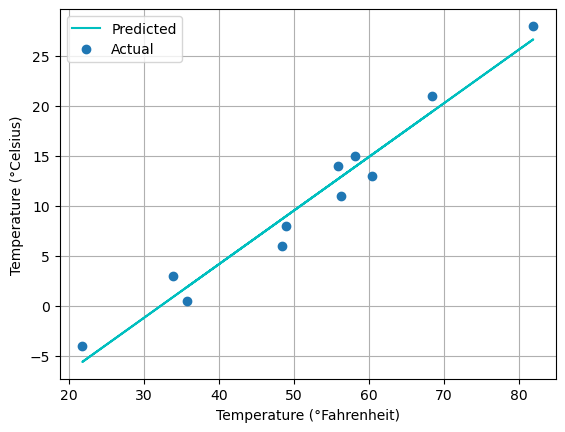

In [12]:
t_p = model(t_u)

#scale back
t_u /= normalization_factor
t_p /= normalization_factor
t_c /= normalization_factor

fig = plt.figure(dpi=100)
plt.grid(True)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy(), 'c-', label="Predicted")
plt.plot(t_u.numpy(), t_c.numpy(), 'o', label="Actual")
plt.legend()
plt.show()